In [1]:
import findspark
findspark.init()
from pyspark.ml.feature import StringIndexer
from pyspark.sql import Row
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit, regexp_replace
from pyspark.sql.functions import desc
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql.types import IntegerType
from pyspark.sql import DataFrame
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
from scipy import spatial
import pandas as pd



**Spark Initialization**

In [2]:
def init_spark():
    spark = SparkSession \
        .builder     .master("local[*]") \
        .appName("Python Spark SQL basic example") \
        .config("spark.executor.memory", "70g") \
    .config("spark.driver.memory", "50g") \
     .config("spark.memory.offHeap.enabled",True) \
     .config("spark.memory.offHeap.size","16g").getOrCreate()
    return spark


**Restaurant file Read**

In [3]:
spark = init_spark()
sc = spark.sparkContext
restaurant_file_name = "C:/Users/saich/Documents/Bigdata Project/zomato_restaurant.csv"
reviews_file_name = "C:/Users/saich/Documents/Bigdata Project/zomato_reviews.csv"

restaurant_df = spark.read.option("wholeFile", True).option("multiline", True).option("header", True)\
    .option("inferSchema", "True").csv(restaurant_file_name)
restaurant_df = restaurant_df.select(["restaurant_id", "categories", "TotalReviews", "name", "city"]).filter(restaurant_df['restaurant_id'] != "#NAME?").filter(restaurant_df['TotalReviews'] > 5).na.drop()
restaurant_df.show(10)


+--------------------+--------------------+------------+--------------------+----------+
|       restaurant_id|          categories|TotalReviews|                name|      city|
+--------------------+--------------------+------------+--------------------+----------+
|vcNAWiLM4dR7D2nww...|Doctors;Health & ...|           7|   Eric Goldberg, MD| Bengaluru|
|JwUE5GmEO-sH1FuwJ...|         Restaurants|          26|Pine Cone Restaurant| De Forest|
|uGykseHzyS5xAMWoN...|              Dinner|          16|Deforest Family R...| De Forest|
|LRKJF43s9-3jG9Lgx...|Food;Ice Cream & ...|           7|            Culver's| De Forest|
|oLctHIA1AxmsgOuu4...|Television Statio...|          10|Charter Communica...|Mc Farland|
|rdAdANPNOcvUtoFgc...|              Dinner|          33|Green Lantern Res...|Mc Farland|
|_wZTYYL7cutanzAnJ...|Bars;American (Tr...|          31|Beach House Resta...|Mc Farland|
|XrzTVrJAjs0yYLvhF...|Hotels & Travel;B...|           9|Parsonage Bed & B...|Mc Farland|
|UgjVZTSOaYoEvws_l...

**Restaurant City and Category bargraph**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27044 entries, 0 to 27043
Data columns (total 5 columns):
restaurant_id    27044 non-null object
categories       27044 non-null object
TotalReviews     27044 non-null int32
name             27044 non-null object
city             27044 non-null object
dtypes: int32(1), object(4)
memory usage: 950.9+ KB


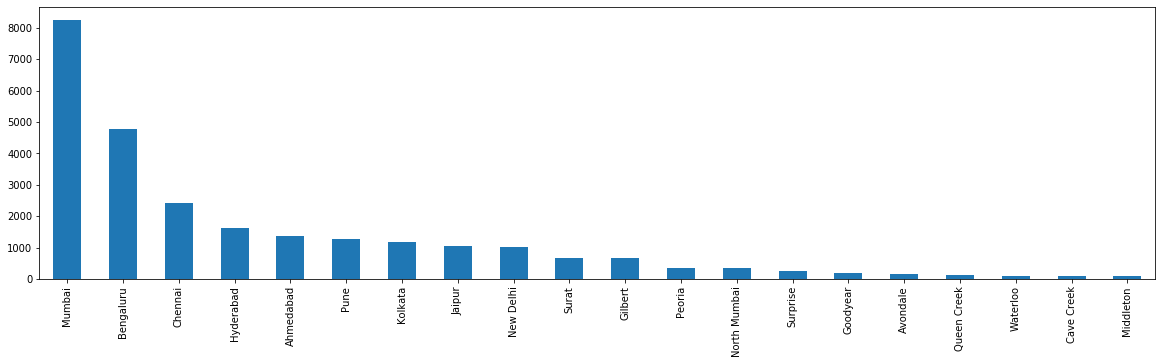

In [4]:
restaurant_pandas=restaurant_df.toPandas()
restaurant_pandas.info()
restaurant_pandas['city'].value_counts()[:20].plot.bar(figsize=(20,5))

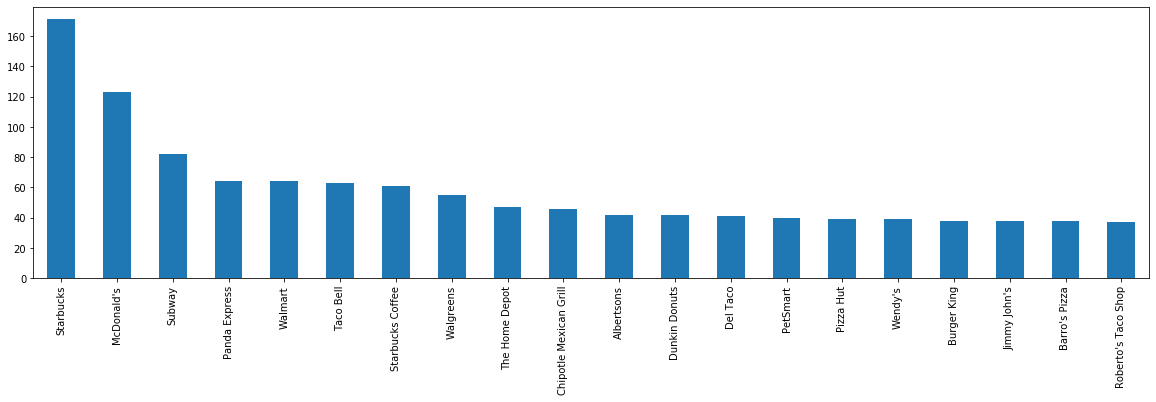

In [5]:
restaurant_pandas['name'].value_counts()[:20].plot.bar(figsize=(20,5))

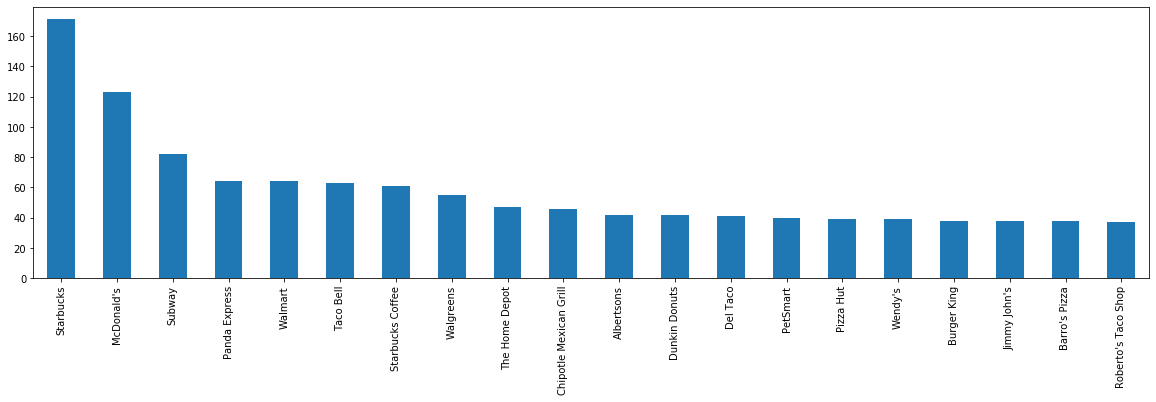

In [6]:
restaurant_pandas['name'].value_counts()[:20].plot.bar(figsize=(20,5))

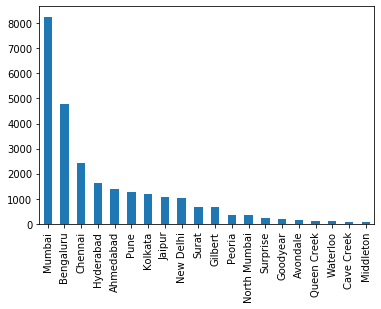

In [7]:
restaurant_pandas=restaurant_pandas['city'].value_counts()[:20]

restaurant_pandas.plot.bar()
restaurant_df=restaurant_df.filter(restaurant_df.city=="Kolkata")

**Review file Read**

In [8]:
reviews_df = spark.read.option ("wholeFile", True).option ("multiline", True).option ("header", True) \
    .option ("inferSchema", "True").csv (reviews_file_name, header=True)
reviews_df = reviews_df.withColumn ('user_id', regexp_replace ('user_id', '=-', ''))
reviews_df = reviews_df.select(["restaurant_id", "user_id", "user_rating"]).filter(reviews_df['restaurant_id'] != "#NAME?").filter(reviews_df['user_id'] != "#NAME?").na.drop()

+--------------------+--------------------+-----------+
|       restaurant_id|             user_id|user_rating|
+--------------------+--------------------+-----------+
|vcNAWiLM4dR7D2nww...|Xqd0DzHaiyRqVH3WR...|          5|
|vcNAWiLM4dR7D2nww...|H1kH6QZV7Le4zqTRN...|          2|
|vcNAWiLM4dR7D2nww...|zvJCcrpm2yOZrxKff...|          4|
|vcNAWiLM4dR7D2nww...|KBLW4wJA_fwoWmMhi...|          4|
|vcNAWiLM4dR7D2nww...|zvJCcrpm2yOZrxKff...|          4|
|vcNAWiLM4dR7D2nww...|Qrs3EICADUKNFoUq2...|          1|
|vcNAWiLM4dR7D2nww...|jE5xVugujSaskAoh2...|          5|
|vcNAWiLM4dR7D2nww...|QnhQ8G51XbUpVEyWY...|          5|
|JwUE5GmEO-sH1FuwJ...|zvNimI98mrmhgNOOr...|          4|
|JwUE5GmEO-sH1FuwJ...|p4ySEi8PEli0auZGB...|          4|
+--------------------+--------------------+-----------+
only showing top 10 rows

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1024799 entries, 0 to 1024798
Data columns (total 3 columns):
restaurant_id    1024799 non-null object
user_id          1024799 non-null obj

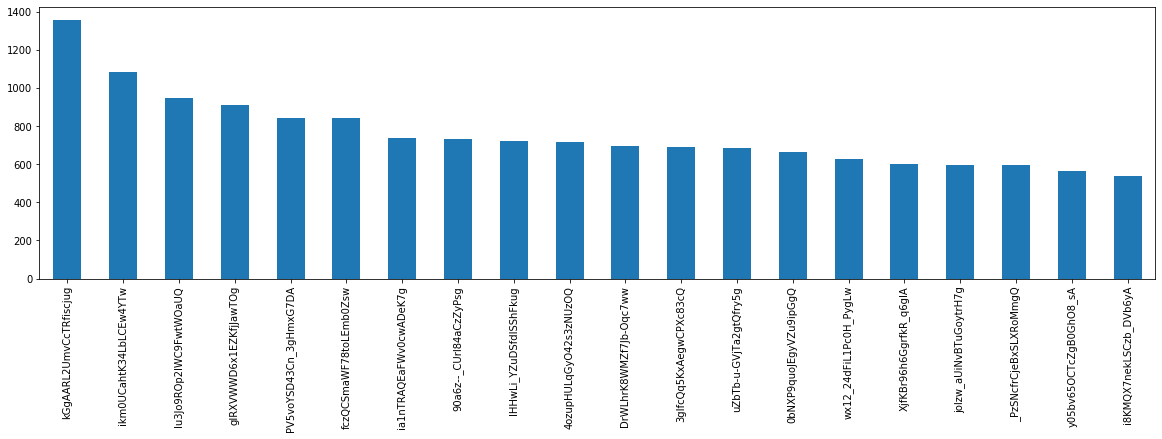

In [9]:
reviews_df.show(10)
review_pandas=reviews_df.toPandas()
review_pandas.info()
review_pandas=review_pandas['user_id'].value_counts()[:20].plot.bar(figsize=(20,5))


**Review Graph**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 467036 entries, 0 to 467035
Data columns (total 7 columns):
restaurant_id    467036 non-null object
user_id          467036 non-null object
user_rating      467036 non-null int32
categories       467036 non-null object
TotalReviews     467036 non-null int32
name             467036 non-null object
city             467036 non-null object
dtypes: int32(2), object(5)
memory usage: 21.4+ MB


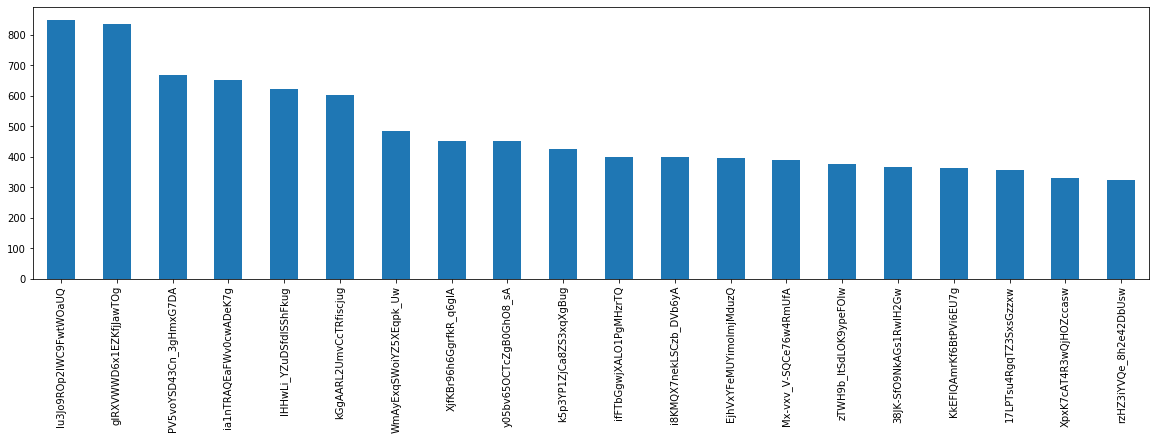

In [10]:

restaurant_rating_pandas=reviews_df.join(restaurant_df, ['restaurant_id']).toPandas()
restaurant_rating_pandas['user_id'].value_counts()[:20].plot.bar(figsize=(20,5))
restaurant_rating_pandas.info()



**Restaurants and Review Join**

In [11]:
restaurant_reviews_df = reviews_df.join(restaurant_df, ['restaurant_id'])

restaurant_reviews_df_new=restaurant_reviews_df.select(["restaurant_id", "user_id", "user_rating","name"])

In [12]:
restaurant_reviews_df.show(10)

+--------------------+--------------------+-----------+--------------------+------------+--------------------+------+
|       restaurant_id|             user_id|user_rating|          categories|TotalReviews|                name|  city|
+--------------------+--------------------+-----------+--------------------+------------+--------------------+------+
|uzztTCsg3XAKlYqmL...|fPHLPrymsyb6WSFFK...|          4|Arts & Entertainm...|           7|Psychic Eye Book ...|Mumbai|
|uzztTCsg3XAKlYqmL...|PV5voYSD43Cn_3gHm...|          4|Arts & Entertainm...|           7|Psychic Eye Book ...|Mumbai|
|uzztTCsg3XAKlYqmL...|xQZpIwtb5rI9gVX8M...|          5|Arts & Entertainm...|           7|Psychic Eye Book ...|Mumbai|
|uzztTCsg3XAKlYqmL...|HkOZSO6pN7u5NG7yj...|          3|Arts & Entertainm...|           7|Psychic Eye Book ...|Mumbai|
|uzztTCsg3XAKlYqmL...|OYQq8sD5Hid4_pb2A...|          5|Arts & Entertainm...|           7|Psychic Eye Book ...|Mumbai|
|uzztTCsg3XAKlYqmL...|DCDDwUkFjK-wxq5lI...|          5|A

In [13]:
restaurant_reviews_df_new=restaurant_reviews_df_new.withColumnRenamed ("user_rating", "rating")
ratings=restaurant_reviews_df_new.withColumn ("rating", restaurant_reviews_df_new.rating.cast(IntegerType()))

ratings = ratings.filter(ratings.restaurant_id.isNotNull())
ratings = ratings.filter(ratings.user_id.isNotNull())


**Indexing UserId's**

In [14]:
indexer = StringIndexer(inputCol="user_id", outputCol="userId").setHandleInvalid("skip")
ratings = indexer.fit(ratings).transform(ratings)
ratings = ratings.withColumn("userId", ratings["userId"].cast(IntegerType()))

**Indexing Restaurant Id's**

In [15]:
temp = StringIndexer(inputCol="restaurant_id", outputCol="restId")
ratings = temp.fit(ratings).setHandleInvalid("skip").transform(ratings)
ratings = ratings.withColumn("restId", ratings["restId"].cast(IntegerType()))
temp_rec = ratings
ratings=ratings.select(["userId", "restId", "rating"])
seed=123

**Training and Test of ALS preparation with hyperparameters**

In [16]:
(training, test) = ratings.randomSplit ([7.0, 3.0 ], seed)
als = ALS (maxIter=10, regParam=0.5, rank=70, userCol="userId", itemCol="restId", ratingCol="rating",
               coldStartStrategy="drop", seed=seed)
model = als.fit (training)
predictions = model.transform (test)
aggDF = predictions.groupBy ('userId', 'restId', 'rating').agg ({'userId' : 'avg'}).agg (
    {'rating' : 'avg'}).collect ()
# mean = predictions.groupBy('userId', 'restId').agg({'userId': 'avg'})
Mmean = (training.groupBy ("restId").agg ({'rating' : 'mean'}))
Umean = (training.groupBy ("userId").agg ({'rating' : 'mean'}))
newDataFrame = training.join (Mmean, "restId").withColumnRenamed ("avg(rating)", "item_mean").join (Umean,
                                                                                                     "userId").withColumnRenamed (
    "avg(rating)", "user_mean")

In [17]:
TrainDataFrame = newDataFrame.withColumn ('user_item_interaction', newDataFrame ['rating'] - (
        newDataFrame ['user_mean'] + newDataFrame ['item_mean'] - aggDF [0] [0]))
TestDataFrame = test.join (Mmean, "restId").withColumnRenamed ("avg(rating)", "item_mean").join (Umean,
                                                                                                  "userId").withColumnRenamed (
    "avg(rating)", "user_mean")

**ALS Predication of RMSE, MSE and MAE**

In [18]:
als = ALS (maxIter=10, regParam=0.5, rank=70, userCol="userId", itemCol="restId",
           ratingCol="user_item_interaction",
           coldStartStrategy="drop", seed=seed)
model1 = als.fit (TrainDataFrame)
predictions = model1.transform (TestDataFrame)
predictions = predictions.withColumn ('newCol',
                                      predictions ['prediction'] + predictions ['user_mean'] + predictions [
                                          'item_mean'] - aggDF [0] [0])

evaluator1 = RegressionEvaluator (metricName="rmse", labelCol="rating",
                                 predictionCol="newCol")
evaluator2 = RegressionEvaluator (metricName="mse", labelCol="rating",
                                 predictionCol="newCol")
evaluator3 = RegressionEvaluator (metricName="mae", labelCol="rating",
                                 predictionCol="newCol")
rmse = evaluator1.evaluate (predictions)
mse = evaluator2.evaluate (predictions)
mae = evaluator3.evaluate (predictions)

print("Rmse",rmse )
print("Mae" , mae)
print("Mse", mse )


Rmse 1.2542102156106667
Mae 0.9522392380468712
Mse 1.5730432649421549


**User restaurants recemmendation**

In [19]:
recs = model.recommendForAllUsers (10).toPandas ()
nrecs = recs.recommendations.apply (pd.Series) \
    .merge (recs, right_index=True, left_index=True) \
    .drop (["recommendations"], axis=1) \
    .melt (id_vars=['userId'], value_name="recommendation") \
    .drop ("variable", axis=1) \
    .dropna ()
nrecs = nrecs.sort_values ('userId')
nrecs = pd.concat ([nrecs ['recommendation'].apply (pd.Series), nrecs ['userId']], axis=1)
nrecs.columns = [

    'RestaurantID_index',
    'Rating',
    'UserID_index'

]


md=temp_rec.select(temp_rec['user_id'],temp_rec['userId'],temp_rec['restaurant_id'],temp_rec['restId'],temp_rec['name'])
md=md.toPandas()
dict1 =dict(zip(md['userId'],md['user_id']))
dict2=dict(zip(md['restId'],md['name']))
nrecs['user_id']=nrecs['UserID_index'].map(dict1)
nrecs['name']=nrecs['RestaurantID_index'].map(dict2)
nrecs.reset_index(drop=True, inplace=True)
new=nrecs[['user_id','name','Rating']]
new['recommendations'] = list(zip(new.name, new.Rating))
res=new[['user_id','recommendations']]
res_new=res['recommendations'].groupby([res.user_id]).apply(list).reset_index()

C:\Users\saich\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


**User Recommendation graphs**

,user_id,recommendations
0,--0mI_q_0D1CdU4P_hoImQ,"[(Gorilla Cafe, 5.184454441070557), (Island De..."
1,--2QZsyXGz1OhiD4-0FQLQ,"[(Jiffy Smog, 5.453772068023682), (Conrado & C..."
2,--4fX3LBeXoE88gDTK6TKQ,"[(SGI-USA Buddhist Center, 3.6345648765563965)..."
3,--9HuvEtLhp21SeIEEltnA,"[(Desert Strings, 5.777367115020752), (Conrado..."
4,--RM-_N1-5AiFSzdU5Gn1Q,"[(SGI-USA Buddhist Center, 4.083629608154297),..."
5,-02It4LFEgradr6uK9KCfA,"[(Smith's Food & Drug Centers Inc, 4.007578849..."
6,-02LD_yedEFQKLuLDO-gWw,"[(Gorilla Cafe, 5.564972400665283), (Gap Outle..."
7,-05sPcciFbK8O_Npx8Dz2A,"[(Kiki de Montparnasse, 4.699824333190918), (D..."
8,-0AH2QoTlvKDf7CcjkJ39Q,"[(Dior Boutique, 4.62614107131958), (Kiki de M..."
9,-0ETqxKsxIBnmJklugoTrg,"[(Rod Stewart: the Hits, 5.019903659820557), (..."


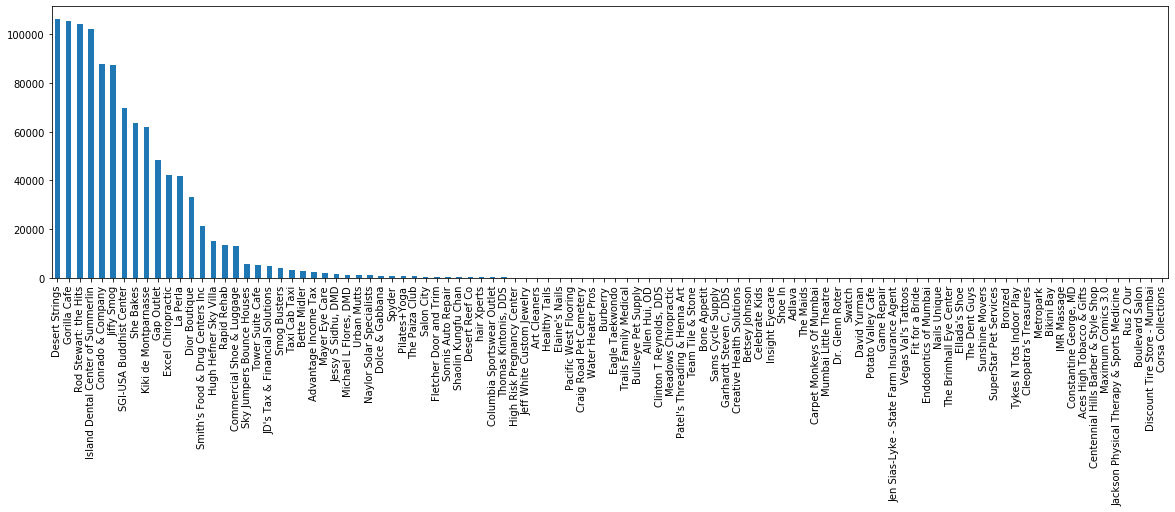

In [20]:
display(res_new[:10])

new['name'].value_counts()[:100].plot.bar(figsize=(20,5))

In [21]:
from IPython.display import display, HTML

HTML(res_new[:10].to_html())

,user_id,recommendations
0,--0mI_q_0D1CdU4P_hoImQ,"[(Gorilla Cafe, 5.184454441070557), (Island Dental Center of Summerlin, 5.088543891906738), (Jiffy Smog, 5.079116344451904), (Smith's Food & Drug Centers Inc, 5.004961967468262), (Excel Chiropractic, 5.074410915374756), (Gap Outlet, 5.012048244476318), (Conrado & Company, 5.047867298126221), (Desert Strings, 5.2633490562438965), (Rod Stewart: the Hits, 5.109673023223877), (She Bakes, 5.036159515380859)]"
1,--2QZsyXGz1OhiD4-0FQLQ,"[(Jiffy Smog, 5.453772068023682), (Conrado & Company, 5.515221118927002), (Rod Stewart: the Hits, 5.545391082763672), (Island Dental Center of Summerlin, 5.498248100280762), (Kiki de Montparnasse, 5.419234275817871), (SGI-USA Buddhist Center, 5.447929859161377), (Desert Strings, 5.646049976348877), (Dior Boutique, 5.4303998947143555), (She Bakes, 5.423991680145264), (Gorilla Cafe, 5.569714546203613)]"
2,--4fX3LBeXoE88gDTK6TKQ,"[(SGI-USA Buddhist Center, 3.6345648765563965), (Jiffy Smog, 3.654212713241577), (Kiki de Montparnasse, 3.638648509979248), (Conrado & Company, 3.6969664096832275), (Smith's Food & Drug Centers Inc, 3.6880786418914795), (Desert Strings, 3.790461301803589), (Rod Stewart: the Hits, 3.7048873901367188), (She Bakes, 3.6323153972625732), (Island Dental Center of Summerlin, 3.6704890727996826), (Gorilla Cafe, 3.7463314533233643)]"
3,--9HuvEtLhp21SeIEEltnA,"[(Desert Strings, 5.777367115020752), (Conrado & Company, 5.7255940437316895), (Rod Stewart: the Hits, 5.723484516143799), (Kiki de Montparnasse, 5.681183338165283), (SGI-USA Buddhist Center, 5.63124418258667), (Island Dental Center of Summerlin, 5.640102863311768), (Gorilla Cafe, 5.686911106109619), (Hugh Hefner Sky Villa, 5.629560470581055), (Dior Boutique, 5.713301658630371), (La Perla, 5.716302871704102)]"
4,--RM-_N1-5AiFSzdU5Gn1Q,"[(SGI-USA Buddhist Center, 4.083629608154297), (Gorilla Cafe, 4.165872573852539), (Rod Stewart: the Hits, 4.15041446685791), (Kiki de Montparnasse, 4.08016300201416), (Conrado & Company, 4.098049640655518), (Jiffy Smog, 4.07993221282959), (Island Dental Center of Summerlin, 4.125988960266113), (She Bakes, 4.065993309020996), (Dior Boutique, 4.068657398223877), (Desert Strings, 4.233871936798096)]"
5,-02It4LFEgradr6uK9KCfA,"[(Smith's Food & Drug Centers Inc, 4.0075788497924805), (Jiffy Smog, 4.075085639953613), (Desert Strings, 4.201727867126465), (Jessy S Sidhu, DMD, 4.053071975708008), (Gorilla Cafe, 4.156524181365967), (Excel Chiropractic, 4.019711017608643), (She Bakes, 4.0502424240112305), (Island Dental Center of Summerlin, 4.006008625030518), (Desert Reef Co, 4.148987293243408), (Commercial Shoe & Luggage, 4.1597466468811035)]"
6,-02LD_yedEFQKLuLDO-gWw,"[(Gorilla Cafe, 5.564972400665283), (Gap Outlet, 5.397806167602539), (Conrado & Company, 5.445097923278809), (Rod Stewart: the Hits, 5.526058673858643), (She Bakes, 5.405583381652832), (SGI-USA Buddhist Center, 5.405655860900879), (Jiffy Smog, 5.461744785308838), (Desert Strings, 5.629502773284912), (Kiki de Montparnasse, 5.421750068664551), (Island Dental Center of Summerlin, 5.466639041900635)]"
7,-05sPcciFbK8O_Npx8Dz2A,"[(Kiki de Montparnasse, 4.699824333190918), (Desert Strings, 4.813791751861572), (Dior Boutique, 4.692044734954834), (She Bakes, 4.662740707397461), (Rod Stewart: the Hits, 4.751060962677002), (Island Dental Center of Summerlin, 4.717610836029053), (SGI-USA Buddhist Center, 4.661372661590576), (Conrado & Company, 4.7333784103393555), (Gorilla Cafe, 4.796158313751221), (La Perla, 4.6747870445251465)]"
8,-0AH2QoTlvKDf7CcjkJ39Q,"[(Dior Boutique, 4.62614107131958), (Kiki de Montparnasse, 4.599857807159424), (SGI-USA Buddhist Center, 4.56780481338501), (La Perla, 4.620334148406982), (Conrado & Company, 4.572333812713623), (Desert Strings, 4.680549621582031), (Tower Suite Cafe, 4.542444705963135), (Rod Stewart: the Hits, 4.644946098327637), (Gorilla Cafe, 4.610330104827881), (Island Dental Center of Summerlin, 4.559782981872559)]"
9,-0ETqxKsxIBnmJklugoTrg,"[(Rod Stewart: the Hits, 5.